In [13]:
import pandas as pd
import numpy as np
from pool.error_analysis import ActuatorErrorAnalysis, DebugErrorAnalysis

ea=ActuatorErrorAnalysis()
dea=DebugErrorAnalysis()
data = pd.read_csv('./results/error_data_0.5_degrees.csv', sep=',',decimal='.')
data=data.dropna()     #drop all rows that have any NaN values
data.head()

,real_point_id,C_x,C_y,T_x,T_y,pocket_id,P_x,P_y,deviation_angle,b,...,intercept,slope_X1T,intercept_X1T,slope_X2T,intercept_X2T,X_calculated_x,X_calculated_y,Q_x,Q_y,delta
0,0.0,505.538407,102.116429,345.590467,276.768101,5.0,462.211248,485.60708,0.017316,239.194744,...,502.599502,0.65564,50.185006,1.266998,-161.094355,326.674860,243.810555,464.664840,484.236935,2.810233
3,0.0,505.538407,102.116429,345.590467,276.768101,5.0,462.211248,485.60708,-0.415671,239.194744,...,508.854990,0.65564,50.185006,1.266998,-161.094355,333.044710,240.898839,425.755184,505.965036,41.755131
7,0.0,505.538407,102.116429,345.590467,276.768101,5.0,462.211248,485.60708,-0.416894,239.194744,...,508.872774,0.65564,50.185006,1.266998,-161.094355,333.058044,240.894177,425.675179,506.009712,41.846765
8,0.0,505.538407,102.116429,345.590467,276.768101,5.0,462.211248,485.60708,-0.460601,239.194744,...,509.508466,0.65564,50.185006,1.266998,-161.094355,333.525682,240.734215,422.869256,507.576608,45.060543
9,0.0,505.538407,102.116429,345.590467,276.768101,5.0,462.211248,485.60708,0.032154,239.194744,...,502.386466,0.65564,50.185006,1.266998,-161.094355,326.316903,244.018601,466.940927,482.965912,5.417161


### Check a specific configuration

Each row of the dataset represents the resut a random shot with an error due to the vision system

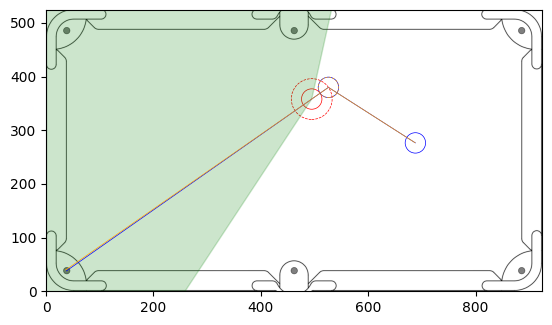

In [14]:
import matplotlib.pyplot as plt

real_point_id=123
idx_of_deviated_config=0 
fig, ax = plt.subplots()
ax.set_xlim((0, dea.pool_table_size[0]))
ax.set_ylim((0, dea.pool_table_size[1]))

sub_data=data[(data['real_point_id']==real_point_id)]
rows=sub_data.to_dict('records')
ax=dea.draw_pool_table_with_pockets(ax)
# we read from first row of sub_data, since the following rows will be the same:
row=rows[idx_of_deviated_config]
ax=dea.draw_ideal_configuration(ax,row)
ax=dea.draw_region_of_interest(ax,row)
ax=dea.draw_real_configuration(ax,row)
ax.plot()  
plt.show()

### Dificulty of the shot

We divide our shots in 3 categories depending on the angle: the closest the angle is to 180 degrees, the better


In [15]:
data['difficulty_angle']=np.pi-data['alpha']-data['beta']
data.loc[(data['difficulty_angle']<np.pi) & (data['difficulty_angle']> (5/6)*np.pi), 'difficulty_category'] = 1
data.loc[(data['difficulty_angle']<(5/6)*np.pi) & (data['difficulty_angle']> (4/6)*np.pi), 'difficulty_category'] = 2
data.loc[(data['difficulty_angle']<(4/6)*np.pi) & (data['difficulty_angle']> (3/6)*np.pi), 'difficulty_category'] = 3

### Visualization of data

Scatter plots of some varaible vs delta

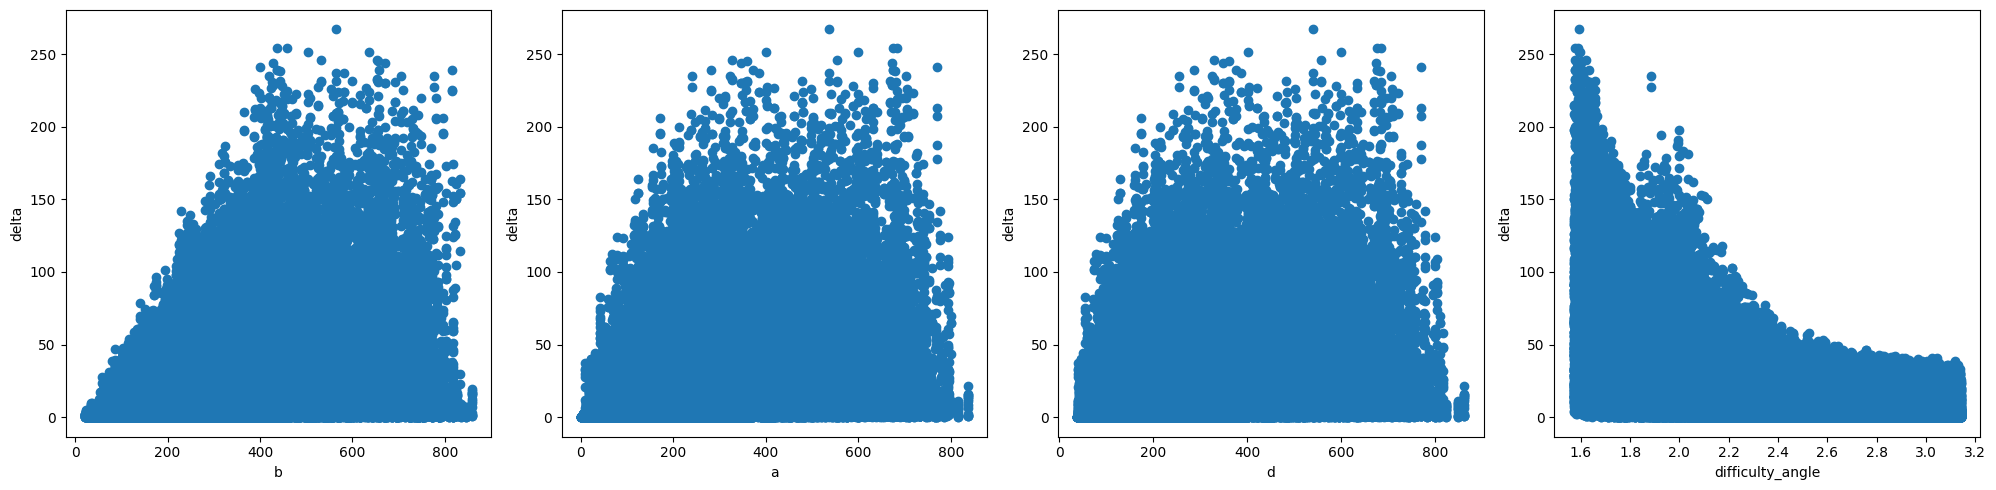

In [16]:
import numpy as np
import matplotlib.pyplot as plt

y = data['delta'].values
x=['b','a','d','difficulty_angle']

fig = plt.figure(1,figsize=(20, 5))

columns = 4
rows = 1

for i,col_name in zip(range(1, columns*rows+1),x):

    x=data[col_name].values
    fig.add_subplot(rows, columns, i)
    plt.scatter(x, y)
    plt.xlabel(col_name)
    plt.ylabel('delta')

plt.tight_layout()
plt.show()

Histograms of delta and its categories

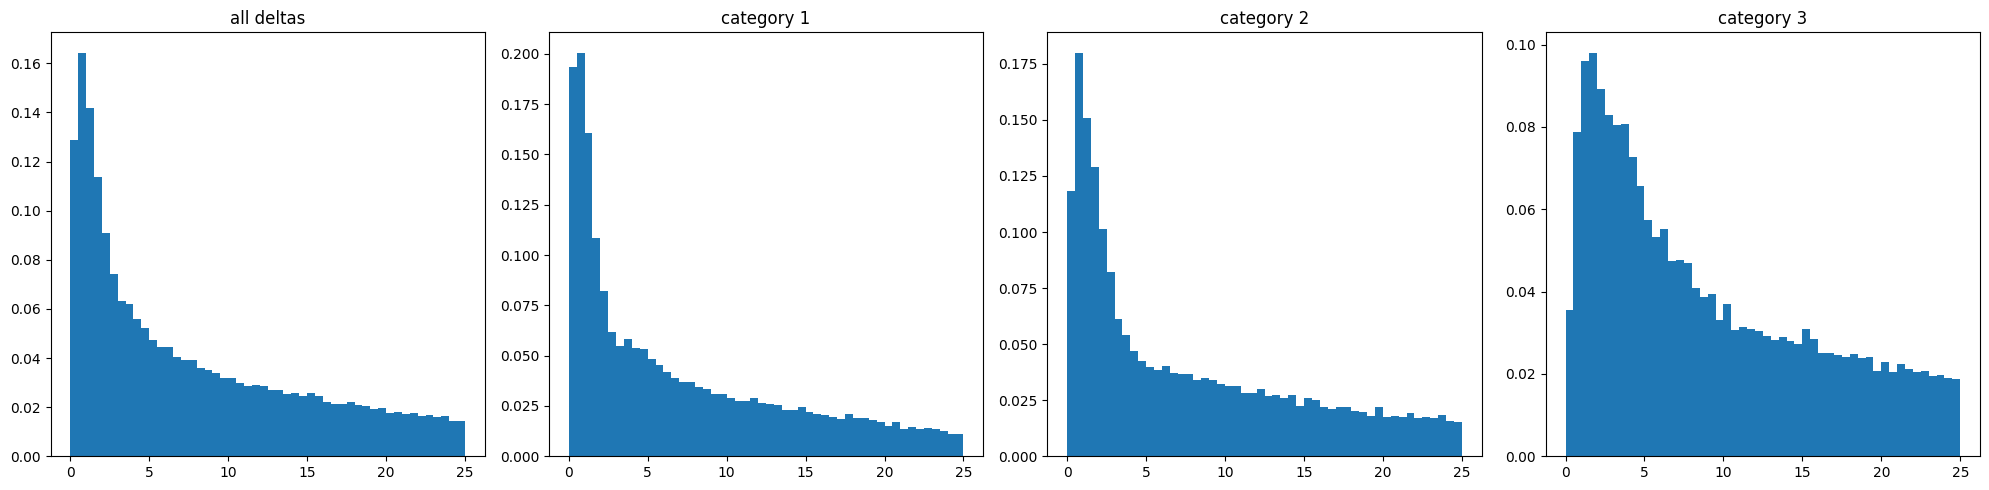

In [17]:
import numpy as np
import matplotlib.pyplot as plt

deltas=data['delta'].values
deltas_category1=data[data['difficulty_category']==1]['delta'].values
deltas_category2=data[data['difficulty_category']==2]['delta'].values
deltas_category3=data[data['difficulty_category']==3]['delta'].values
list_deltas=[deltas,deltas_category1,deltas_category2,deltas_category3]

fig = plt.figure(1,figsize=(20, 5))

columns = 4
rows = 1

for category,i,delta_type in zip(['all deltas', 'category 1', 'category 2', 'category 3'],range(1, columns*rows+1),list_deltas):

    fig.add_subplot(rows, columns, i)
    plt.title(category)
    plt.hist(delta_type, bins=50,range=[0, 25], density=True)

plt.tight_layout()
plt.show()


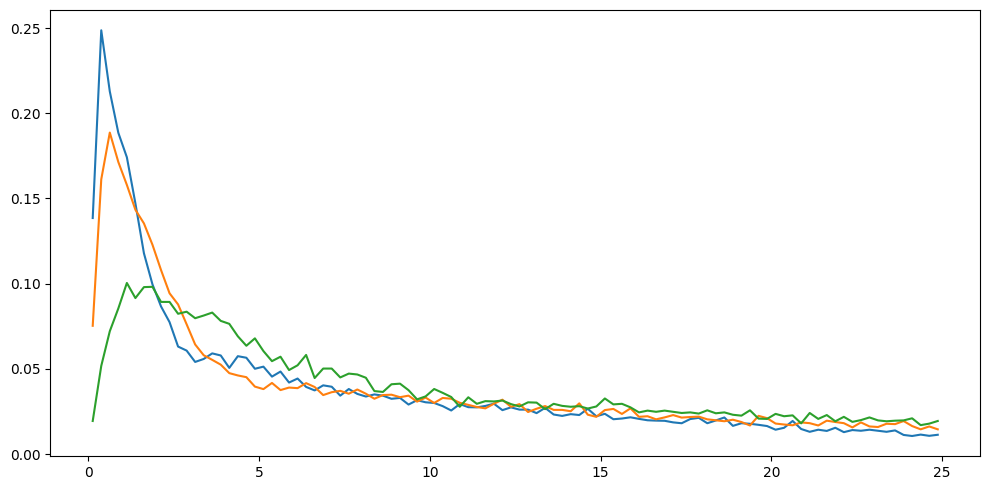

In [18]:
fig = plt.figure(1,figsize=(10, 5))

n,x=np.histogram(deltas_category1, bins = 100,range=[0, 25],density=True)
bin_centers = 0.5*(x[1:]+x[:-1])
plt.plot(bin_centers,n) ## using bin_centers rather than edges

n,x=np.histogram(deltas_category2, bins = 100,range=[0, 25],density=True)
bin_centers = 0.5*(x[1:]+x[:-1])
plt.plot(bin_centers,n) ## using bin_centers rather than edges

n,x=np.histogram(deltas_category3, bins = 100,range=[0, 25],density=True)
bin_centers = 0.5*(x[1:]+x[:-1])
plt.plot(bin_centers,n) ## using bin_centers rather than edges

plt.tight_layout()
plt.show()


### Probability of getting an error below a certain threshold

probability of error below 10mm:  0.7014780091703168


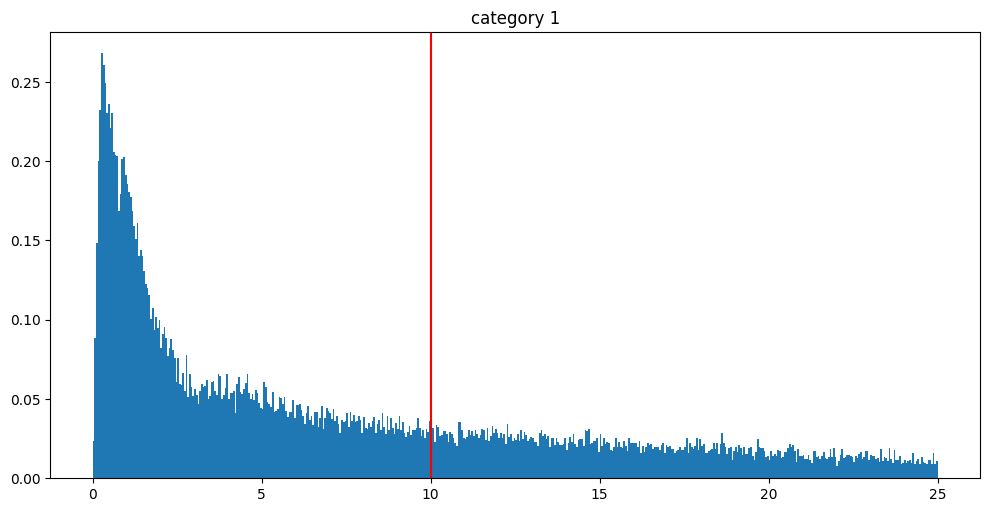

probability of error below 10mm:  0.6626114937337698


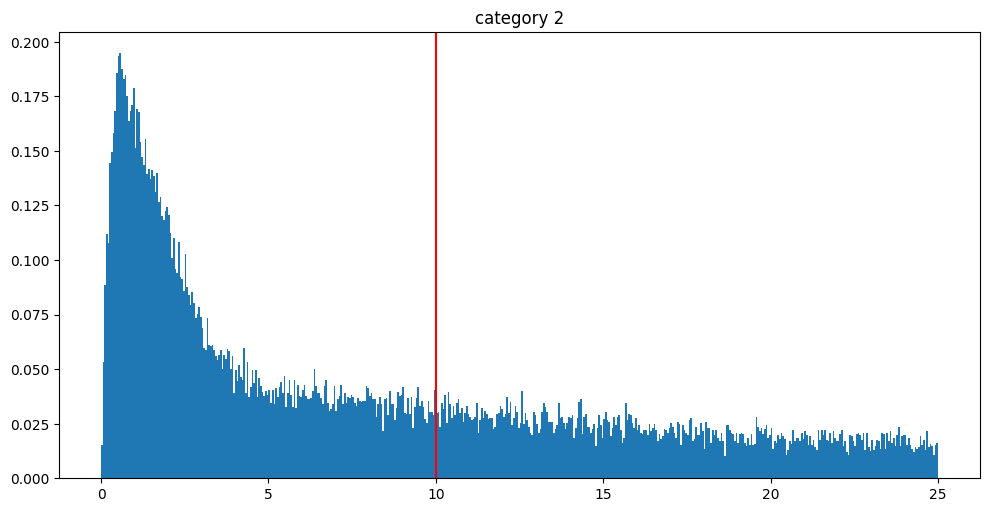

probability of error below 10mm:  0.6185056472632493


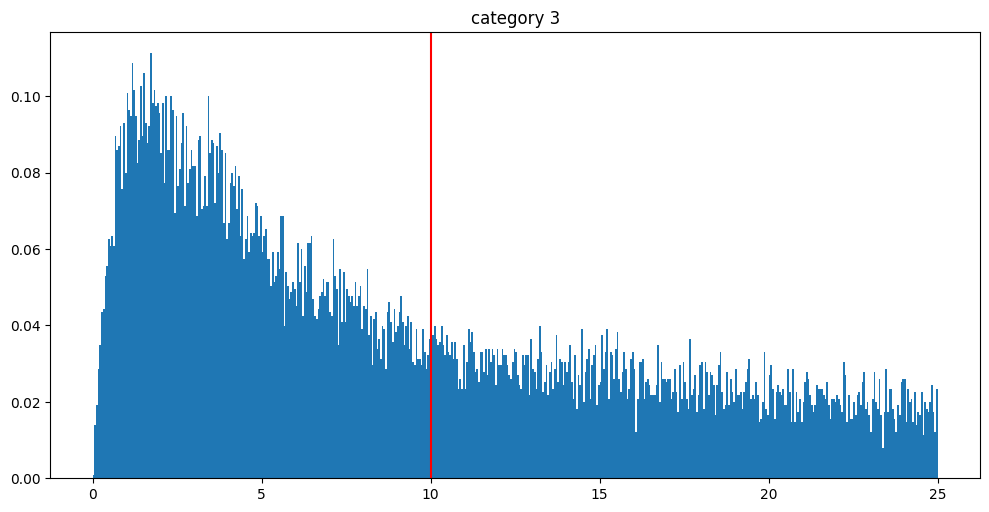

In [19]:
threshold=10
num_bins=500

for category,deltas_category in enumerate([deltas_category1,deltas_category2,deltas_category3]):
    arr_pdf,arr_bins=np.histogram(deltas_category, bins = num_bins,range=[0, 25],density=True)

    #in order to match dimensions of bins and pdf arrays we get rid of last bins element
    arr_bins_cropped=arr_bins[:-1]
    arr_bins_thresholded=arr_bins_cropped[arr_bins_cropped<threshold]

    #in order to have the same dimension between _pdf and np.diff(_bins), _bins need to have one 
    #more element than _pdf (i.e., _pdf need to have one less element than _bins)
    arr_pdf_thresholded=arr_pdf[arr_bins_cropped<threshold][:-1]
    area=np.sum(arr_pdf_thresholded* np.diff(arr_bins_thresholded))
    print(f'probability of error below {threshold}mm: ', area)

    #plot computed probability
    fig = plt.figure(1,figsize=(10, 5))
    plt.hist(deltas_category, bins = num_bins, range=[0, 25],density=True)
    plt.axvline(x=threshold, color='r')
    plt.tight_layout()
    plt.title(f'category {category+1}')
    plt.show()
